<a href="https://colab.research.google.com/github/vanujiash9/BTVN/blob/main/Practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Woking with data**

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

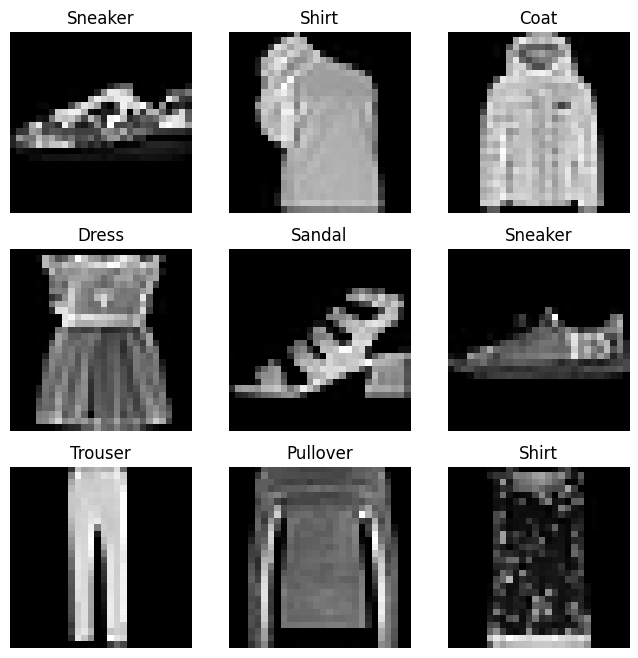

In [ ]:
import matplotlib.pyplot as plt
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


# **Creating Models**

In [ ]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
  )
)


# **Optimizing the Model Parameters**

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss  # Thêm return để lấy giá trị loss


In [ ]:
# Danh sách lưu giá trị loss qua các epoch
test_losses = []

epochs = 40
for t in range(epochs):
    print(f'Epoch {t + 1} \n----------------------------')
    train(train_dataloader, model, loss_fn, optimizer)
    test_loss = test(test_dataloader, model, loss_fn)  # Hàm test trả về giá trị loss
    test_losses.append(test_loss)  # Lưu lại giá trị loss của từng epoch

print('Done!')

Epoch 1 
----------------------------
loss: 2.294793  [   64/60000]
loss: 2.283839  [ 6464/60000]
loss: 2.254359  [12864/60000]
loss: 2.251057  [19264/60000]
loss: 2.233584  [25664/60000]
loss: 2.192160  [32064/60000]
loss: 2.204147  [38464/60000]
loss: 2.155409  [44864/60000]
loss: 2.149597  [51264/60000]
loss: 2.103982  [57664/60000]
Test Error: 
 Accuracy: 51.8%, Avg loss: 2.101835 

Epoch 2 
----------------------------
loss: 2.115783  [   64/60000]
loss: 2.100179  [ 6464/60000]
loss: 2.024694  [12864/60000]
loss: 2.045450  [19264/60000]
loss: 1.977933  [25664/60000]
loss: 1.910306  [32064/60000]
loss: 1.935230  [38464/60000]
loss: 1.839372  [44864/60000]
loss: 1.847172  [51264/60000]
loss: 1.748596  [57664/60000]
Test Error: 
 Accuracy: 60.6%, Avg loss: 1.760960 

Epoch 3 
----------------------------
loss: 1.804511  [   64/60000]
loss: 1.769073  [ 6464/60000]
loss: 1.634790  [12864/60000]
loss: 1.682125  [19264/60000]
loss: 1.559092  [25664/60000]
loss: 1.526610  [32064/60000]
lo

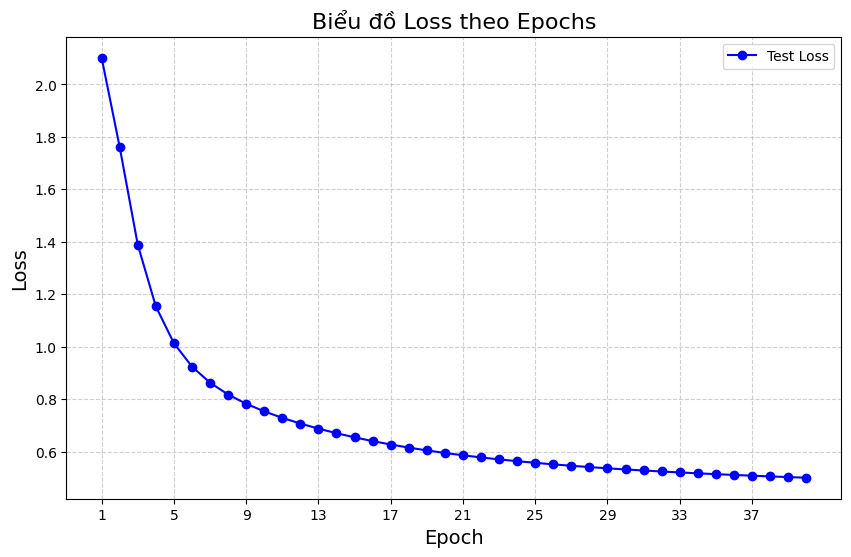

In [ ]:
import matplotlib.pyplot as plt

# Vẽ đồ thị loss theo epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(test_losses) + 1), test_losses, marker='o', linestyle='-', color='b', label='Test Loss')
plt.title("Biểu đồ Loss theo Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xticks(range(1, len(test_losses) + 1, max(1, len(test_losses) // 10)))  # Điều chỉnh nhãn trục x
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# **Saving and Loading Models**

In [ ]:
model_path = '/content/drive/MyDrive/Machine learning - Deep learning/Machine learning - Deep learning/Day 3: Neural Networks & Unsupervised 🧠/full_model.pth'
torch.save(model, model_path)


Predicted: "Ankle boot", Actual: "Ankle boot"


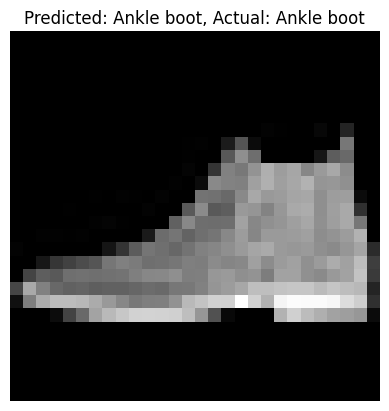

In [ ]:
import matplotlib.pyplot as plt

# Define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Chọn mẫu đầu tiên từ tập test
x, y = test_data[0][0], test_data[0][1]

# Dự đoán nhãn của ảnh đó
model.eval()
with torch.no_grad():
    x_device = x.to(device)
    pred = model(x_device)
    predicted_label = classes[pred.argmax().item()] # Now classes is defined
    actual_label = classes[y] # Now classes is defined

print(f'Predicted: "{predicted_label}", Actual: "{actual_label}"')

# Hiển thị ảnh
plt.imshow(x.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
plt.axis("off")
plt.show()

Predicted: "Shirt", Actual: "Shirt"


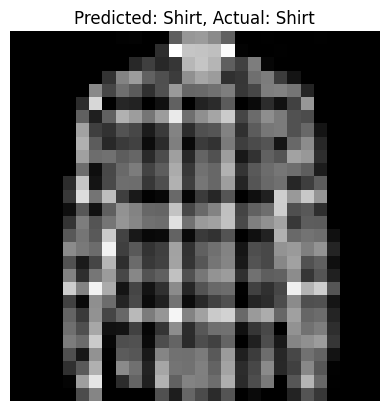

In [ ]:
import matplotlib.pyplot as plt

# Chọn mẫu đầu tiên từ tập test
x, y = test_data[7][0], test_data[7][1]

# Dự đoán nhãn của ảnh đó
model.eval()
with torch.no_grad():
    x_device = x.to(device)
    pred = model(x_device)
    predicted_label = classes[pred.argmax().item()]
    actual_label = classes[y]

print(f'Predicted: "{predicted_label}", Actual: "{actual_label}"')

# Hiển thị ảnh
plt.imshow(x.squeeze(), cmap="gray")
plt.title(f"Predicted: {predicted_label}, Actual: {actual_label}")
plt.axis("off")
plt.show()


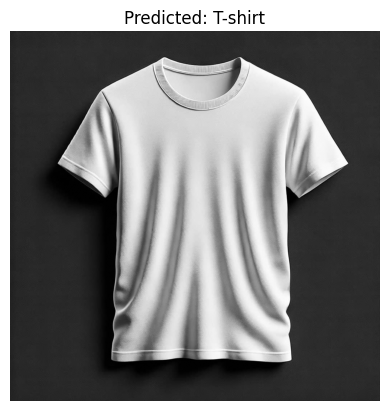

In [ ]:
# import torch
# import torchvision.transforms as T
# from PIL import Image
# import matplotlib.pyplot as plt

# # Giả sử bạn có model, device, classes giống như trong code cũ
# # model: Mô hình đã huấn luyện
# # device: "cpu" hoặc "cuda"
# # classes: Danh sách 10 nhãn của FashionMNIST

# # 1. Đọc ảnh và chuyển đổi
# image_path = "/content/drive/MyDrive/Machine learning - Deep learning/áo.jpg"  # Đường dẫn đến ảnh bên ngoài
# image = Image.open(image_path).convert('L')  # Chuyển ảnh sang grayscale

# # 2. Tạo transforms: Resize -> ToTensor
# transform = T.Compose([
#     T.Resize((28, 28)),  # Resize về 28x28
#     T.ToTensor()         # Chuyển thành tensor [C, H, W], giá trị [0,1]
# ])

# # 3. Biến đổi ảnh thành tensor
# image_tensor = transform(image)  # shape [1, 28, 28]
# # Thêm một chiều batch: shape [1, 1, 28, 28]
# image_tensor = image_tensor.unsqueeze(0).to(device)

# # 4. Mô hình dự đoán
# model.eval()
# with torch.no_grad():
#     pred = model(image_tensor)
#     predicted_idx = pred.argmax(dim=1).item()
#     predicted_label = classes[predicted_idx]

# # 5. Hiển thị ảnh và kết quả
# plt.imshow(image, cmap="gray")
# plt.title(f"Predicted: {predicted_label}")
# plt.axis("off")
# plt.show()


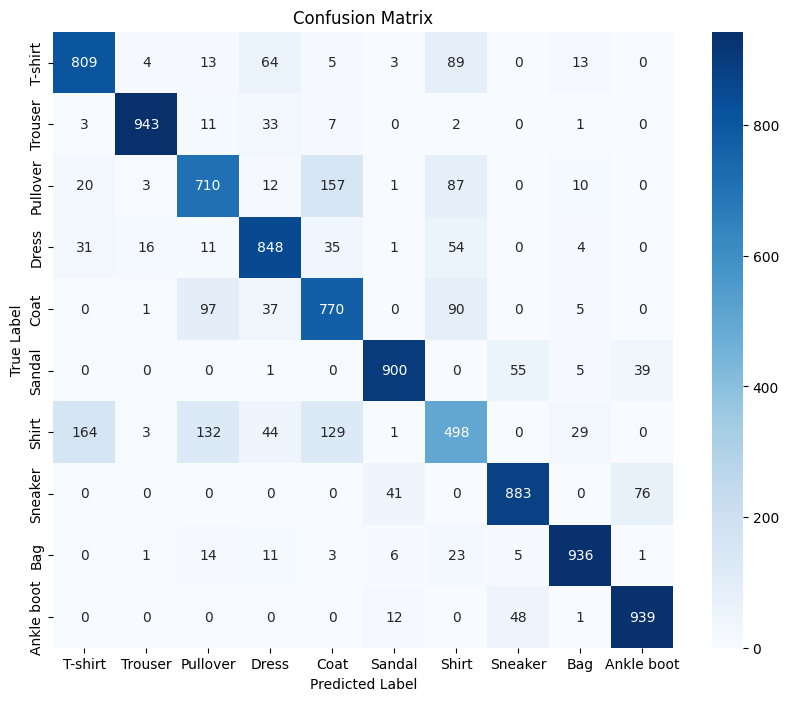

In [ ]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import torchvision

# 1. Lấy nhãn thực tế và dự đoán trên tập test
y_true = []
y_pred = []

# Assuming 'test_dataloader' is the correct DataLoader for the test dataset
test_loader = test_dataloader

model.eval()
with torch.no_grad():
    for images, labels in test_loader:  # test_loader is the DataLoader for the test dataset
        images, labels = images.to(device), labels.to(device)  # Move to the device
        outputs = model(images)  # Prediction logits
        _, predicted = torch.max(outputs, 1)  # Get the predicted label
        y_true.extend(labels.cpu().numpy())  # Save the true label
        y_pred.extend(predicted.cpu().numpy())  # Save the predicted label

# 2. Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # FashionMNIST labels

# 3. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()